In [1]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from core.preprocessing.uk_holidays import retrieve_holiday_dates
from core.preprocessing.data_utils import fill_zero_consumptions
from core.feature_engineering.feature_creation import create_features
from core.visualisation.plot_utils import boxplot_electricity_consumption, plot_week_consumption
import seaborn as sns

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from dask_ml.preprocessing import Categorizer
# from glum import GeneralizedLinearRegressor, TweedieDistribution
# from lightgbm import LGBMRegressor
# # import scipy.optimize
# from sklearn.compose import ColumnTransformer
# from sklearn.metrics import auc, mean_absolute_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler

# from ps3.data import create_sample_split, load_transform


## Load Data

In [2]:
DEMAND_DATA_PATH = Path.cwd().parent / 'data' / 'demand_data' / 'historic_demand_2009_2024.csv'
WEATHER_DATA_PATH = Path.cwd().parent / 'data' / 'weather_data' / 'all_weather_data.csv'

df_demand = pd.read_csv(DEMAND_DATA_PATH, index_col=0)
df_weather = pd.read_csv(WEATHER_DATA_PATH, index_col=0)

# Change column names to lower case and drop id (row number)
df_demand.columns = df_demand.columns.str.lower()
df_demand.head()


,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1


## Data understanding

The [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) includes a description of all the columns. It is intuitive that the inflow and outflow of the connection channels in the dataset has little contribution to the predication of UK demand. The generation of wind and solar also have little impact in electricity demand. Hence I will use the 3 columns below and drop the other columns. I will introduce the weather data and join with the demand for the prediction of the UK electricity demand.

* SETTLEMET_DATA: date in format dd/mm/yyyy
* SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred
* TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.

In [3]:
df_demand.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
count,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,...,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,103296.000000,103296.000000,33168.000000,33168.000000,278592.000000
mean,24.500230,31186.856489,32627.150352,28388.517068,1266.183760,4442.451068,878.978851,8664.639013,6.670271,304.958427,...,52.560770,504.322741,-125.472042,-50.637086,175.249849,413.590420,114.916696,1687.110498,187.359594,0.022571
std,13.853822,7830.469632,7713.762584,7090.759507,960.981771,1956.656441,1710.119384,5867.370555,39.196603,528.734713,...,352.310414,541.202147,230.119018,262.791267,421.016595,650.851017,491.937519,1819.688334,555.345444,0.148530
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1030.000000,-1215.000000,-505.000000,-585.000000,-1023.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.000000
25%,12.750000,24906.000000,26580.000000,22674.000000,550.000000,2098.000000,0.000000,2024.750000,0.000000,8.000000,...,0.000000,0.000000,-303.000000,-207.000000,0.000000,0.000000,0.000000,262.000000,0.000000,0.000000
50%,24.500000,30492.000000,31780.000000,27752.000000,1014.000000,4831.000000,0.000000,11503.000000,0.000000,11.000000,...,0.000000,726.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,1523.000000,0.000000,0.000000
75%,36.250000,36915.000000,38096.000000,33616.000000,1722.000000,6527.000000,884.000000,13080.000000,0.000000,367.000000,...,0.000000,994.000000,24.000000,0.000000,324.000000,1095.000000,93.000000,3021.000000,428.250000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5587.000000,6622.000000,11224.000000,17197.000000,893.000000,2019.000000,...,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1436.000000,1.000000


In [4]:
df_demand.shape

(278592, 22)

In [5]:
df_demand.columns

Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer',
       'viking_flow', 'is_holiday'],
      dtype='object')

In [6]:
# There are Nan values in the nsl_flow, eleclink_flow and scottish_transfer, viking_flow columns that is due to the fact that the data is not available for the years 2020-2024. We will drop these columns as they are not relevant for our analysis.
# the channels are not in operation before certain years hence the flow data is Nan. We will drop these columns as they are not 
# relevant for our analysis.
df_demand.isna().any()
df_demand_clean = df_demand[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Sort values by date
df_demand_clean.sort_values(by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True)

/var/folders/g2/rxb_hqs14sj0lzydxpy6nmw40000gn/T/ipykernel_62576/3588579965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_clean.sort_values(by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True)


In [7]:
df_demand_clean.shape

(278592, 4)

In [8]:
# Each year UK changes clock in the last Sunday of March and October. 
# This means that the number of settlement periods in a day changes from 48 to 46 and from 48 to 50. 
# I will check if the dataset has the correct number of settlement periods at clock change days
period_counts = df_demand_clean.groupby('settlement_date')['settlement_period'].count()
clock_change_dates = period_counts[period_counts != 48]
print(f"clock change dates from 2009 to 2024: {clock_change_dates}")

clock change dates from 2009 to 2024: settlement_date
2009-03-29    46
2009-10-25    50
2010-03-28    46
2010-10-31    50
2011-03-27    46
2011-10-30    50
2012-03-25    46
2012-10-28    50
2013-03-31    46
2013-10-27    50
2014-03-30    46
2014-10-26    50
2015-03-29    46
2015-10-25    50
2016-03-27    46
2016-10-30    50
2017-03-26    46
2017-10-29    50
2018-03-25    46
2018-10-28    50
2019-03-31    46
2019-10-27    50
2020-03-29    46
2020-10-25    50
2021-03-28    46
2021-10-31    50
2022-03-27    46
2022-10-30    50
2023-03-26    46
2023-10-29    50
2024-03-31    46
2024-10-27    50
Name: settlement_period, dtype: int64


In [9]:
# Bank holidays are very important in demand forecasting as the electricity demand on a holiday is often very low comparing with non-holidays. 
# The dataset has is_holiday columns. Next is to verify the holiday dates.
# Online there is [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I use to get UK holidays and verify the dates in the dataset.
to_date = pd.to_datetime(df_demand_clean['settlement_date']).max().date()
holiday_dates = retrieve_holiday_dates(subdiv='England', 
                                       from_date=dt.date(2009, 1, 1), 
                                       to_date=to_date)
holiday_dates_in_data = df_demand_clean[df_demand_clean['is_holiday'] == 1]['settlement_date'].unique()

missing_holidays = set(holiday_dates) - set(holiday_dates_in_data)
print(f"Missing holidays in data: {missing_holidays}")



Missing holidays in data: set()


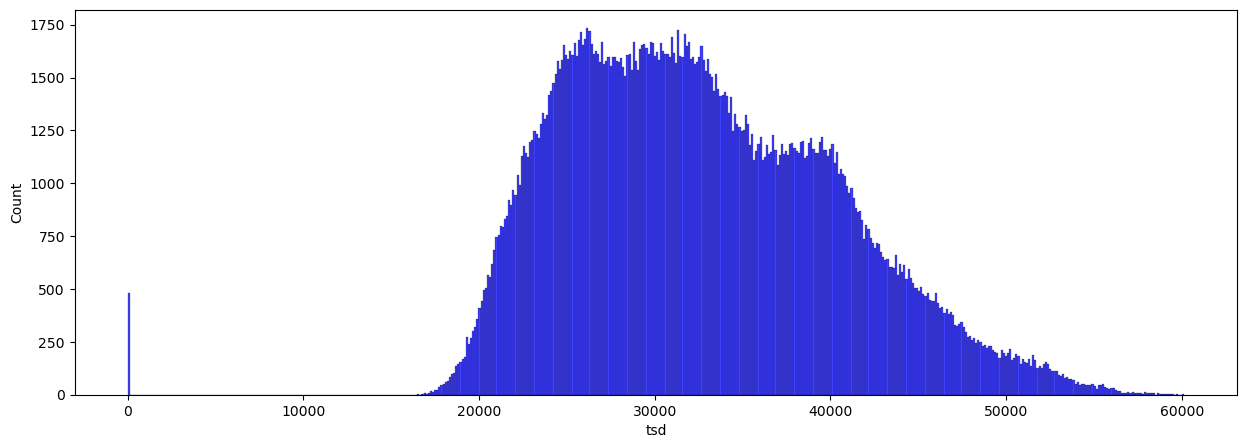

In [10]:
# There are some 0 values in the demand data
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df_demand_clean, x="tsd", bins=500, ax=ax, color="b");

In [11]:
df_demand_clean = fill_zero_consumptions(df_demand_clean)

/Users/lizzy/JavaPythonProjects/Mphil/d100_ds/uk_electricity_consumption/core/preprocessing/data_utils.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = pd.to_datetime(df["settlement_date"]).dt.year


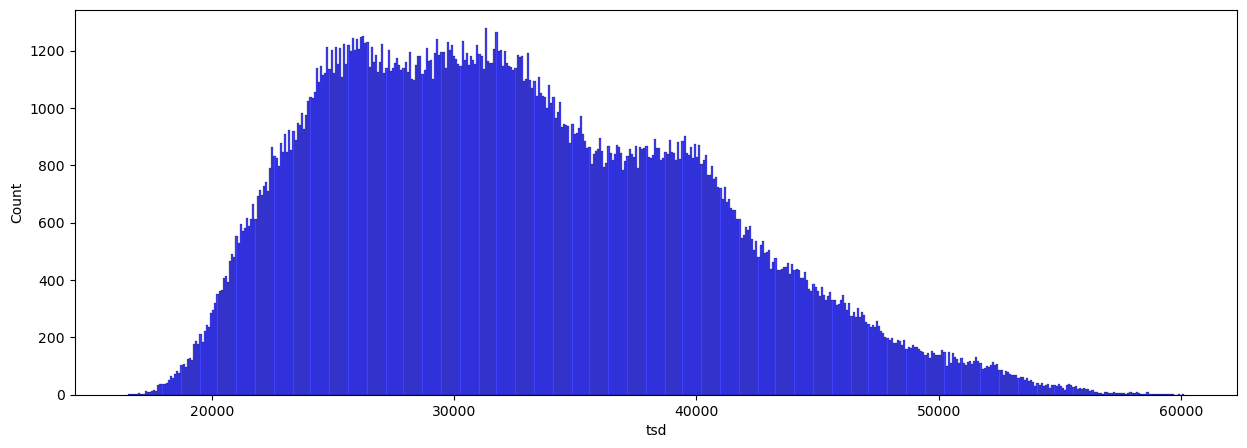

In [12]:
# Check if there are still 0 values in the demand data
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df_demand_clean, x="tsd", bins=500, ax=ax, color="b");

## Weather data understanding

In [13]:
# Check if there are any missing values in the weather data
df_weather.isna().any()

date                        False
min_temp °c                 False
max_temp °c                 False
rain mm                     False
humidity %                  False
cloud_cover %               False
wind_speed km/h             False
wind_direction              False
wind_direction_numerical    False
dtype: bool

In [14]:
# Daily weather data by each location. I take the average of the weather data of all locations as the daily weather for UK national wide.
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather_by_date = df_weather.groupby('date')[['min_temp °c', 'max_temp °c', 'rain mm', 'humidity %',
       'cloud_cover %', 'wind_speed km/h']].mean()

In [15]:
df_weather_by_date.head()

,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h
date,,,,,,
2009-01-01,-1.988072,1.886680,0.114115,83.870775,32.479125,10.300199
2009-01-02,-0.705765,3.755467,0.046918,88.558648,43.236581,13.721670
2009-01-03,-2.089463,2.667992,0.102386,80.930417,25.284294,10.890656
2009-01-04,-2.043738,1.956262,0.517296,83.399602,58.314115,11.992048
2009-01-05,-1.789264,2.685885,0.772763,84.389662,37.079523,17.214712


In [16]:
df_weather_by_date.shape

(5681, 6)

## EDA and Feature engineering
In this section, I visualise the data that has been prepared in order to understand the original feature. The consumption exihibits strong seasonanity as expected and slightly descrease trend by year. So I add new features that constits of different bits of information embedded in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions.

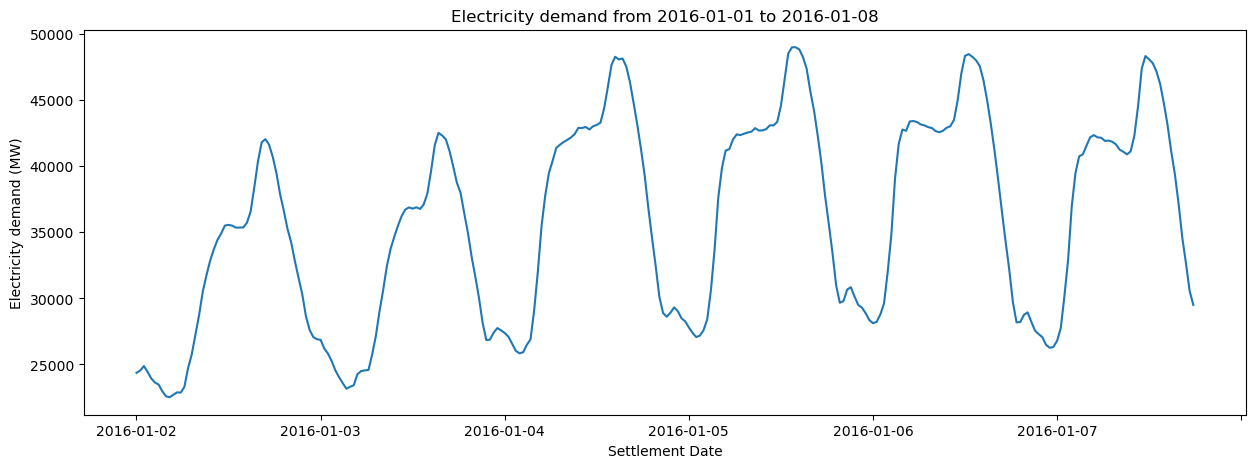

In [17]:
df_demand_clean.set_index("settlement_date", inplace=True)
df_demand_clean.sort_index(inplace=True)

plot_week_consumption(df_demand_clean, 
                      "2016-01-01", 
                      "2016-01-08", 
                      xlabel="Settlement Date", 
                      ylabel="Electricity demand (MW)",
                      title="Electricity demand from 2016-01-01 to 2016-01-08")

In [18]:
df_demand_clean.index = pd.to_datetime(df_demand_clean.index)
df_demand_clean = create_features(df_demand_clean)

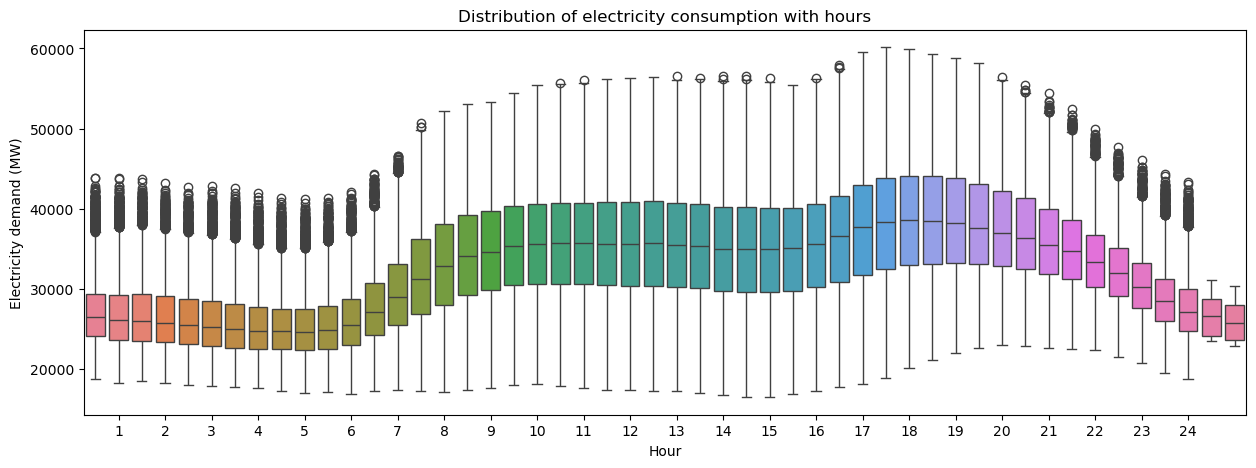

In [19]:
boxplot_electricity_consumption(df=df_demand_clean, 
                                x="settlement_period", 
                                y="tsd",
                                hue="settlement_period",
                                xlabel="Hour",
                                ylabel="Electricity demand (MW)",
                                xticklabel=range(1, 25),
                                title="Distribution of electricity consumption with hours",
                                colours=50)

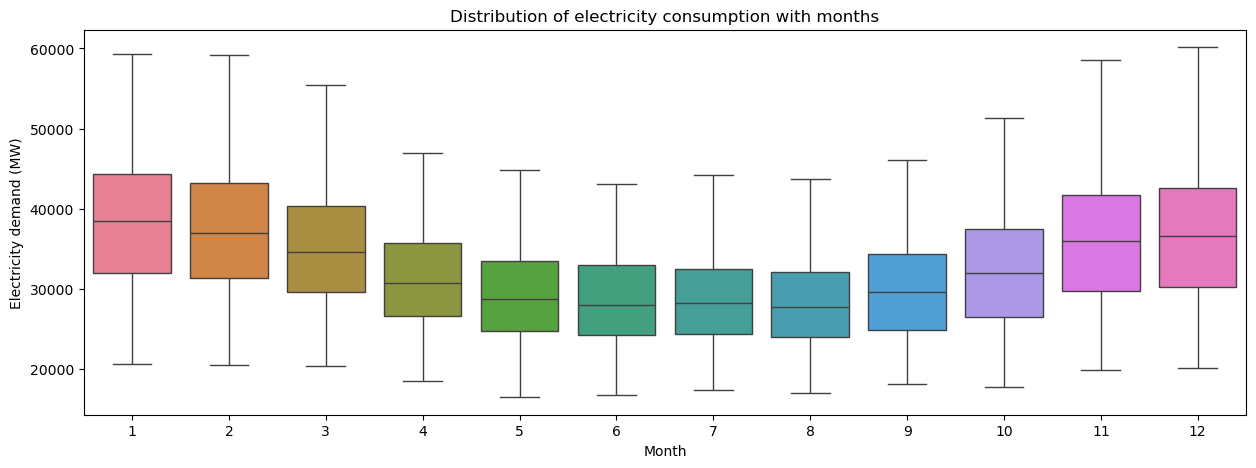

In [20]:
boxplot_electricity_consumption(df=df_demand_clean, 
                                x="month", 
                                y="tsd",
                                xlabel="Month",
                                ylabel="Electricity demand (MW)",
                                hue="month",
                                title="Distribution of electricity consumption with months",
                                colours=12)

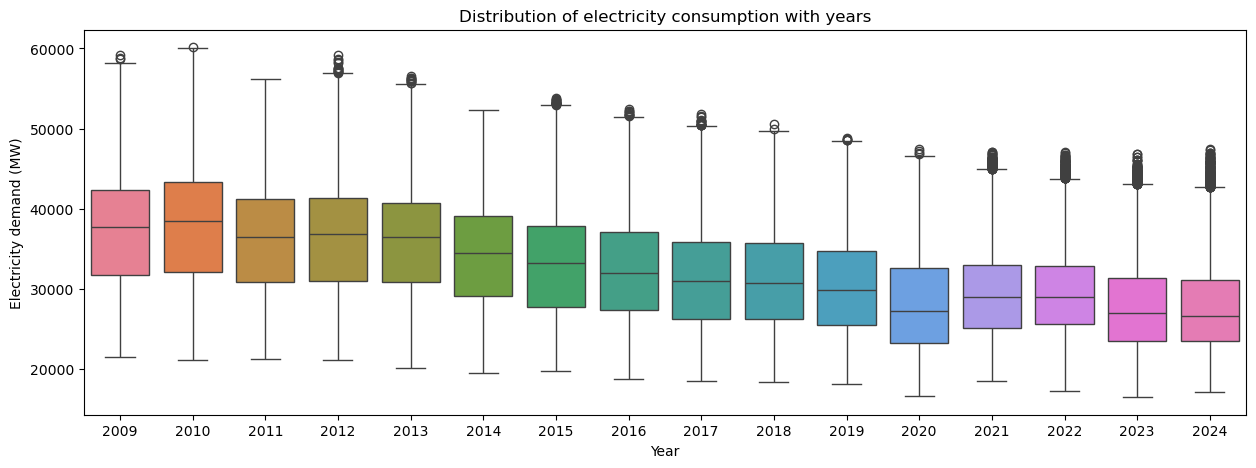

In [21]:
boxplot_electricity_consumption(df=df_demand_clean,
                                x="year",
                                y="tsd",
                                hue="year",
                                xlabel="Year",
                                ylabel="Electricity demand (MW)",
                                title="Distribution of electricity consumption with years",
                                colours=16)

/Users/lizzy/JavaPythonProjects/Mphil/d100_ds/uk_electricity_consumption/core/visualisation/plot_utils.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabel)


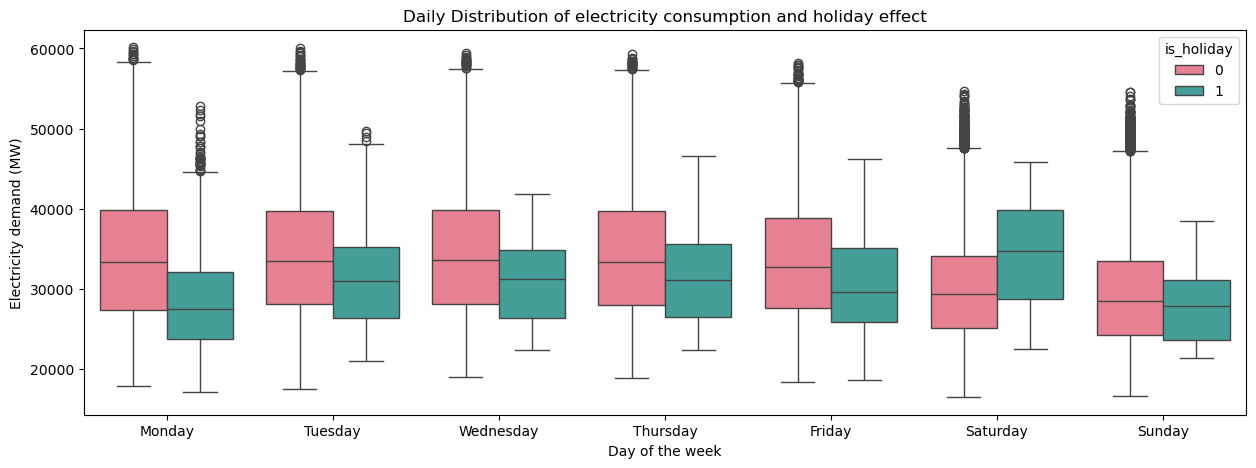

In [22]:
boxplot_electricity_consumption(df=df_demand_clean,
                                x="day_of_week",
                                y="tsd",
                                hue="is_holiday",
                                xlabel="Day of the week",
                                ylabel="Electricity demand (MW)",
                                xticklabel=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                                title="Daily Distribution of electricity consumption and holiday effect",
                                colours=2,
                                is_legend=True)

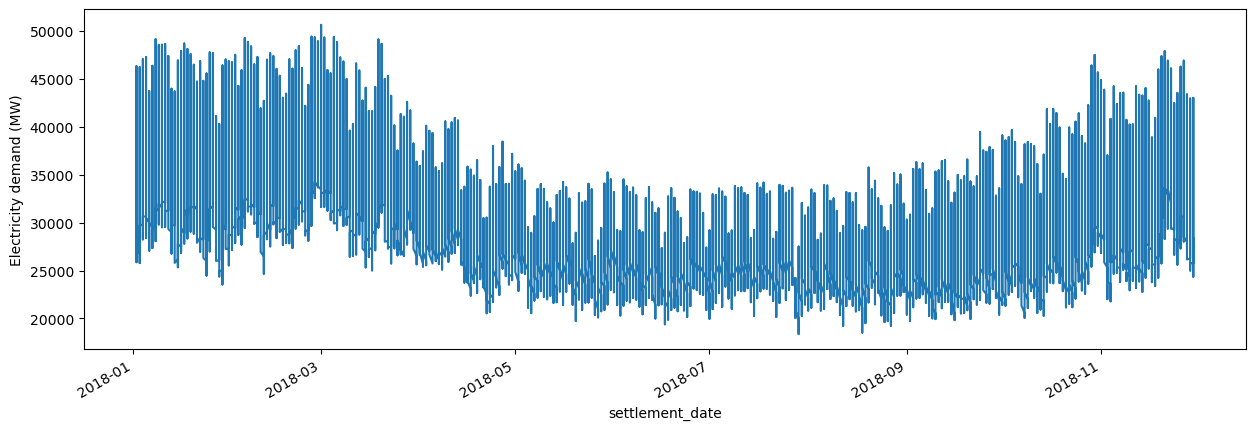

In [23]:
df_demand_clean.loc[(df_demand_clean.index > "2018-01-01") & (df_demand_clean.index < "2018-12-01")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [24]:
# df_demand_clean.reset_index(inplace=True)
df_glm = df_demand_clean.groupby("settlement_date")["tsd"].sum().reset_index()
df_glm["is_holiday"] = df_glm["settlement_date"].apply(
    lambda x: x in holiday_dates.keys()
)

df_glm["is_holiday"] = df_glm["is_holiday"].astype(int)
df_glm.set_index("settlement_date", inplace=True)
df_glm.index = pd.to_datetime(df_glm.index)
df_glm = create_features(df_glm)
df_glm['is_weekday'] = df_glm.index.weekday < 5
df_glm['is_weekend'] = df_glm.index.weekday >= 5
df_glm['is_summer'] = df_glm.index.month.isin([6, 7, 8])
df_glm['is_winter'] = df_glm.index.month.isin([12, 1, 2])


In [25]:
print("Latest date in consumption: " + str(df_glm.index.max().date()))
print("Latest date in weather: " + str(df_weather_by_date.index.max().date()))

df_glm = df_glm.join(df_weather_by_date, how='inner')
df_glm.head()

Latest date in consumption: 2024-11-21
Latest date in weather: 2024-11-12


,tsd,is_holiday,day_of_week,week_of_year,month,quarter,year,is_weekday,is_weekend,is_summer,is_winter,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h
2009-01-01,1849363,0,3,1,1,1,2009,True,False,False,True,-1.988072,1.886680,0.114115,83.870775,32.479125,10.300199
2009-01-02,1974406,0,4,1,1,1,2009,True,False,False,True,-0.705765,3.755467,0.046918,88.558648,43.236581,13.721670
2009-01-03,1952054,0,5,1,1,1,2009,False,True,False,True,-2.089463,2.667992,0.102386,80.930417,25.284294,10.890656
2009-01-04,1968670,0,6,1,1,1,2009,False,True,False,True,-2.043738,1.956262,0.517296,83.399602,58.314115,11.992048
2009-01-05,2271471,0,0,2,1,1,2009,True,False,False,True,-1.789264,2.685885,0.772763,84.389662,37.079523,17.214712


In [26]:
df_glm.columns

Index(['tsd', 'is_holiday', 'day_of_week', 'week_of_year', 'month', 'quarter',
       'year', 'is_weekday', 'is_weekend', 'is_summer', 'is_winter',
       'min_temp °c', 'max_temp °c', 'rain mm', 'humidity %', 'cloud_cover %',
       'wind_speed km/h'],
      dtype='object')

In [27]:
# Let's tune the LGBM to reduce overfitting.
# Steps:
# 1. Define a `GridSearchCV` object with our lgbm pipeline/estimator. Tip: Parameters for a specific step of the pipeline
# can be passed by <step_name>__param. 

# Note: Typically we tune many more parameters and larger grids,
# but to save compute time here, we focus on getting the learning rate
# and the number of estimators somewhat aligned -> tune learning_rate and n_estimators
param_grid = {
    "lgbm__learning_rate": [0.01, 0.05, 0.1],
    "lgbm__n_estimators": [100, 200, 300]
}

cv = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_poisson_deviance",
    verbose=1,
    n_jobs=-1
)
cv.fit(X_train_t, y_train_t, lgbm__sample_weight=w_train_t)

df_test["pp_t_lgbm"] = cv.best_estimator_.predict(X_test_t)
df_train["pp_t_lgbm"] = cv.best_estimator_.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm"]),
    )
)



NameError: name 'GridSearchCV' is not defined

[]

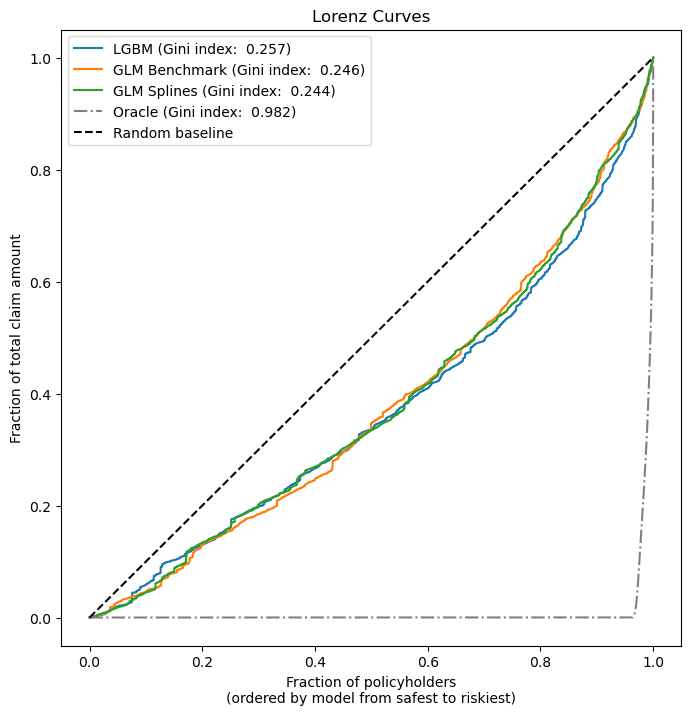

In [9]:
# Let's compare the sorting of the pure premium predictions


# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [
    ("LGBM", df_test["pp_t_lgbm"]),
    ("GLM Benchmark", df_test["pp_t_glm1"]),
    ("GLM Splines", df_test["pp_t_glm2"]),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += f" (Gini index: {gini: .3f})"
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = f"Oracle (Gini index: {gini: .3f})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

## Exercise 4 Starts

/var/folders/g2/rxb_hqs14sj0lzydxpy6nmw40000gn/T/ipykernel_96462/2585024624.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_claims = df.groupby("BonusMalus").apply(lambda x: np.average(x["PurePremium"], weights=x["Exposure"]))


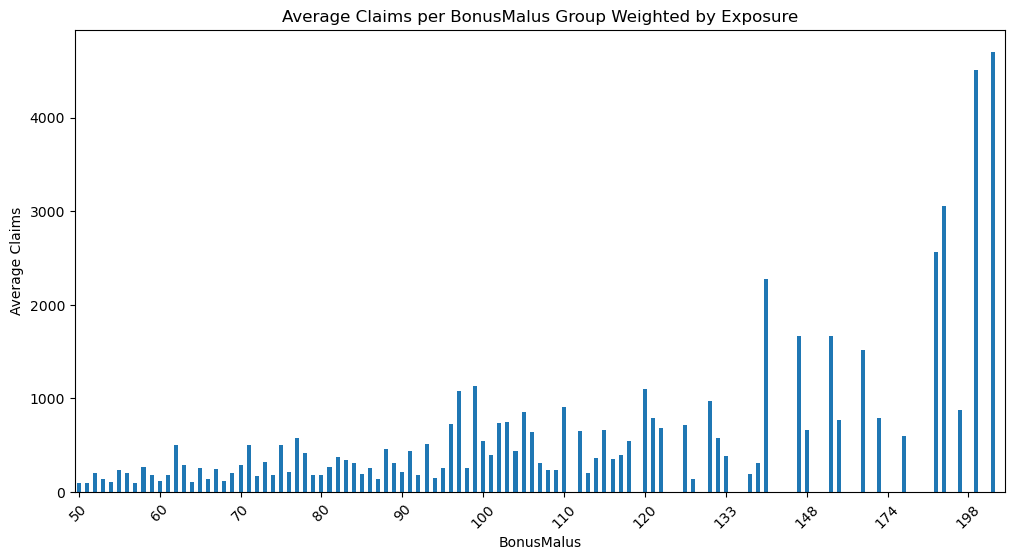

In [ ]:
# Create a plot of the average claims per BonusMalus group weighted by exposure.
average_claims = df.groupby("BonusMalus").apply(lambda x: np.average(x["PurePremium"], weights=x["Exposure"]))
plt.figure(figsize=(12, 6))
average_claims.plot(kind='bar')
plt.xlabel('BonusMalus')
plt.ylabel('Average Claims')
plt.title('Average Claims per BonusMalus Group Weighted by Exposure')
plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=12)
plt.show()

### What will/could happen if we do not include a monotonicity constraint?
We can see from the above plot that we do not have exposure in every BonusMalus group. It is likely that there might be edge cases in which the monotonicity breaks. Serveral issues could arise if we do not include a monotonicity constraint in the model.

**Non-intuitive Results:** The model might produce results that do not align with domain knowledge or intuition. For example, the price decreases for customers with lower bonus malus score. 

**Overfitting**: Without constraints, the model might overfit the training data by capturing noise, leading to poor generalization on new data.

**Interpretability**: Monotonicity constraints can make the model more interpretable, as they enforce a consistent relationship between input and output variables.

In summary, including a monotonicity constraint helps ensure that the model behaves in a predictable and interpretable manner, aligning with domain knowledge and improving generalization.

In [ ]:
# Create a new model pipeline or estimator called constrained_lgbm. Introduce an increasing monotonicity constrained for BonusMalus. 
# Note: We have to provide a list of the same length as our features with 0s everywhere except for BonusMalus where we put a 1. 
# See: https://lightgbm.readthedocs.io/en/latest/Parameters.html

monotone_constraints = [0] * len(categoricals) + [1, 0]  # 1 for BonusMalus, 0 for Density and categoricals

constrained_lgbm = Pipeline(
    [
        ("lgbm", LGBMRegressor(objective="tweedie", monotone_constraints=monotone_constraints))
    ]
)

cv_constrained = GridSearchCV(
    constrained_lgbm,
    {
        "lgbm__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "lgbm__n_estimators": [50, 100, 150, 200],
    },
    verbose=2,
)

cv_constrained.fit(X_train_t, y_train_t, lgbm__sample_weight=w_train_t)

df_test["pp_t_lgbm_constrained"] = cv_constrained.best_estimator_.predict(X_test_t)
df_train["pp_t_lgbm_constrained"] = cv_constrained.best_estimator_.predict(X_train_t)

print(
    "training loss constrained_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_constrained_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss constrained_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_constrained_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

Number of total features: 9
Monotone constraints: [0, 0, 0, 0, 0, 0, 0, 1, 0]


[LightGBM] [Fatal] Check failed: (static_cast<size_t>(train_data_->num_total_features())) == (config->monotone_constraints.size()) at /Users/runner/miniforge3/conda-bld/liblightgbm_1728547408595/work/src/boosting/gbdt.cpp, line 58 .



LightGBMError: Check failed: (static_cast<size_t>(train_data_->num_total_features())) == (config->monotone_constraints.size()) at /Users/runner/miniforge3/conda-bld/liblightgbm_1728547408595/work/src/boosting/gbdt.cpp, line 58 .
